In [1]:
from paths import *
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
from tqdm import tqdm


In [2]:

warnings.filterwarnings("ignore", message="`distplot` is a deprecated function")
warnings.filterwarnings("ignore", message="DeprecationWarning")


## Loading Data

In [3]:
sample = "serum"

if sample == "serum":
    filename = GLOBAL_SERUM_DATA_FILENAME
else:
    filename = GLOBAL_STOOL_DATA_FILENAME
    

file_path = os.path.join(DATA_ROOT_PATH, filename)

sheet_name = ["Chemical Annotation", "Sample Meta Data", "Log Transformed Data"]

analyte_metadata = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[0])
patient_metadata = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[1])
data = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[2])

data.head()


,PARENT_SAMPLE_NAME,35,50,55,62,93,98,111,112,117,...,999926106,999926107,999926108,999926109,999926111,999926119,999926158,999926162,999926193,999926220
0,UCSF-06758,0.589314,-0.396834,-0.346427,-0.313341,0.851420,-0.739952,-0.544856,0.874154,-0.240343,...,-0.682286,-0.511435,-0.405570,-0.296065,-1.399005,0.722791,-2.117685,-0.128829,0.164402,-0.501802
1,UCSF-06759,0.049593,0.139420,0.369308,-0.159880,0.238199,-0.249942,-0.490267,-0.172927,-1.654431,...,0.140373,-0.085745,-0.288537,0.532617,-0.524474,0.027085,-0.635392,-0.024504,-0.521084,0.346311
2,UCSF-06760,-0.416035,-1.045957,-0.644778,-0.740068,0.530813,-0.135617,-0.911855,-0.459714,-1.654431,...,0.345986,-0.028342,-0.215191,0.774885,-0.000414,-0.513820,-0.001856,-1.159971,0.273635,-0.517265
3,UCSF-06761,-0.386523,0.151742,0.323162,0.580034,0.368174,0.307989,0.387318,0.176586,-0.504245,...,0.026680,-0.227256,-1.053303,-0.488734,1.394431,0.809892,-0.817902,-2.311686,-2.726539,-0.139303
4,UCSF-06762,-0.352323,-0.064386,0.709778,0.691759,0.359623,-0.057788,-0.368919,0.571490,0.070276,...,0.085673,-0.212734,-0.409145,-1.118993,-0.428157,-0.219333,-0.668027,-2.311686,-1.176159,-0.038116


In [5]:
patient_metadata.columns

Index(['PARENT_SAMPLE_NAME', 'CLIENT_IDENTIFIER', 'NEG', 'POLAR', 'POS EARLY',
       'POS LATE', 'AGE', 'BMI', 'BOX_NUMBER', 'CLIENT_MATRIX',
       'CLIENT_SAMPLE_ID', 'CLIENT_SAMPLE_NUMBER', 'GENDER', 'GROUP_NAME',
       'GROUP_NAME_2', 'GROUP_NAME_3', 'RACE__ETHNICITY', 'SAMPLE_AMOUNT',
       'SAMPLE_AMOUNT_UNITS', 'SAMPLE_BOX_LOCATION', 'SAMPLE_DESCRIPTION',
       'TREATMENT', 'TREATMENT_2', 'VOL_EXTRACTED'],
      dtype='object')

In [41]:
# patient_metadata["VOL_EXTRACTED"].unique()
patient_metadata.loc[:, "site_code"] = patient_metadata["CLIENT_SAMPLE_ID"].apply(lambda x:x[0:3])
patient_metadata.site_code.unique()


array(['717', '716', '718', '715', '765', '764', '714'], dtype=object)

In [67]:
patient_metadata[(patient_metadata.site_code=="765") & (patient_metadata.GROUP_NAME=="MS")]["CLIENT_SAMPLE_ID"].unique().shape


(21,)

In [66]:
2100/500

4.2

## Analyte selection

In [17]:
global_metabolomics_compound_spoke_map = pd.read_csv(os.path.join(OUTPUT_PATH, "global_metabolomics_compound_spoke_map.csv"))

analyte_columns = list(data.columns)
analyte_columns.remove("PARENT_SAMPLE_NAME")

analyte_columns_selected = global_metabolomics_compound_spoke_map[global_metabolomics_compound_spoke_map.CHEM_ID.isin(analyte_columns)]["CHEM_ID"].unique()

data_with_analyte_columns_selected = data[["PARENT_SAMPLE_NAME"]+list(analyte_columns_selected)]


## Merging patient metadata with analyte concentration data

In [37]:
selected_metadata_columns = ["PARENT_SAMPLE_NAME", "CLIENT_IDENTIFIER", "GROUP_NAME", "AGE", "BMI", "GENDER", "CLIENT_SAMPLE_ID", "CLIENT_MATRIX", "TREATMENT", "SAMPLE_AMOUNT_UNITS"]
patient_metadata_selected_columns = patient_metadata[selected_metadata_columns]
patient_metadata_selected_columns.loc[:, 'house'] = (patient_metadata_selected_columns['CLIENT_SAMPLE_ID'].str[:3] + patient_metadata_selected_columns['CLIENT_SAMPLE_ID'].str[-4:])
patient_metadata_selected_columns.loc[:, 'site'] = patient_metadata_selected_columns.loc[:, 'CLIENT_SAMPLE_ID'].str[:3]
le = LabelEncoder()
patient_metadata_selected_columns.loc[:, 'Disease_label'] = le.fit_transform(patient_metadata_selected_columns['GROUP_NAME'])
patient_metadata_selected_columns.loc[:, 'Gender_label'] = le.fit_transform(patient_metadata_selected_columns['GENDER'])

data_with_patient_metadata = pd.merge(data_with_analyte_columns_selected, patient_metadata_selected_columns, on="PARENT_SAMPLE_NAME")
data_with_patient_metadata.head()


,PARENT_SAMPLE_NAME,35,50,62,93,98,111,112,117,144,...,BMI,GENDER,CLIENT_SAMPLE_ID,CLIENT_MATRIX,TREATMENT,SAMPLE_AMOUNT_UNITS,house,site,Disease_label,Gender_label
0,UCSF-06758,0.589314,-0.396834,-0.313341,0.851420,-0.739952,-0.544856,0.874154,-0.240343,0.562101,...,19.422970,F,71701-0004,serum,Treated,uL,7170004,717,1,0
1,UCSF-06759,0.049593,0.139420,-0.159880,0.238199,-0.249942,-0.490267,-0.172927,-1.654431,-0.540335,...,25.501750,F,71601-0150,serum,Off,uL,7160150,716,1,0
2,UCSF-06760,-0.416035,-1.045957,-0.740068,0.530813,-0.135617,-0.911855,-0.459714,-1.654431,-0.672326,...,34.970939,M,71602-0150,serum,Control,uL,7160150,716,0,1
3,UCSF-06761,-0.386523,0.151742,0.580034,0.368174,0.307989,0.387318,0.176586,-0.504245,0.127822,...,26.544467,M,71601-0164,serum,Treated,uL,7160164,716,1,1
4,UCSF-06762,-0.352323,-0.064386,0.691759,0.359623,-0.057788,-0.368919,0.571490,0.070276,-0.425296,...,31.176140,F,71602-0164,serum,Control,uL,7160164,716,0,0


## Reversing the log transformation to the analyte concentration

In [19]:
data_with_patient_metadata_reverse_log_transformed = data_with_patient_metadata.copy()
for analyte in analyte_columns_selected:
    analyte_concentration = data_with_patient_metadata_reverse_log_transformed[analyte].values
    data_with_patient_metadata_reverse_log_transformed.loc[:, analyte] = np.exp(analyte_concentration)
    

## Distribution of concentration values of first 8 analytes

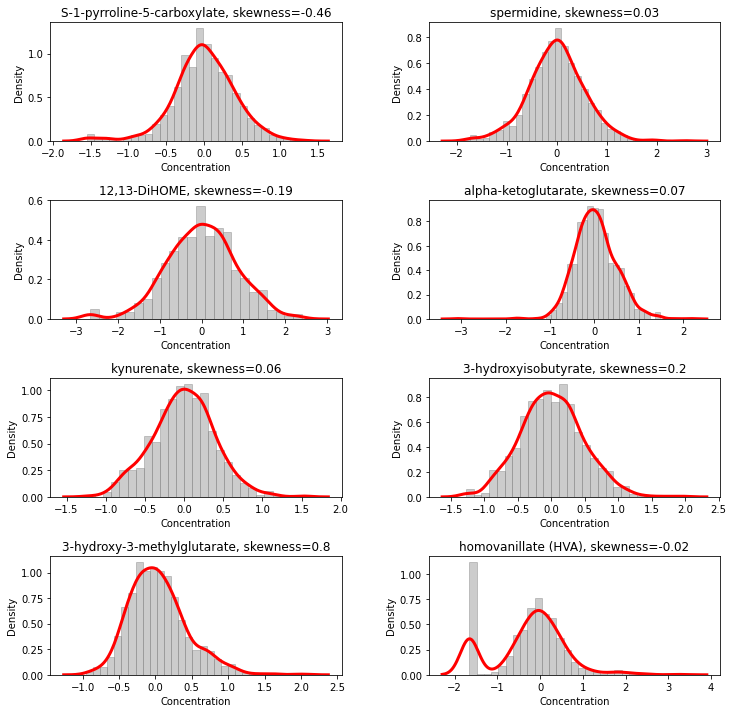

In [20]:
# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

# Flatten the subplot grid for easier indexing
axes = axes.flatten()

df = data_with_patient_metadata
for i, analyte in enumerate(analyte_columns_selected[0:8]):
    analyte_name = analyte_metadata[analyte_metadata["CHEM_ID"]==analyte]["CHEMICAL_NAME"].values[0]
    # Select the data for the current analyte
    subset = df[analyte]
    # Compute the skewness of the data
    skewness = round(subset.skew(), 2)
    # Plot the histogram and kde plot
    sns.distplot(subset, hist=True, kde=True, ax=axes[i], 
                 kde_kws={'color': 'r', 'lw': 3},
                 hist_kws={'color': 'gray', 'edgecolor': 'gray', 'linewidth': 1})
    # Set the title and axis labels
    axes[i].set_title(f"{analyte_name}, skewness={skewness}")
    axes[i].set_xlabel('Concentration')
    axes[i].set_ylabel('Density')
    
# Remove the unused subplots
for i in range(8, len(axes)):
    fig.delaxes(axes[i])
    
# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Show the plot
plt.show()

# print('Saving the figure ...')
# fig_filename = os.path.join(OUTPUT_PATH, "figures", "distribution_of_iMSMS_global_compounds_concentration_full_data_{}_sample_log_transformed.svg".format(sample))
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


## Distribution of concentration values of first 8 analytes after reversing log transformation

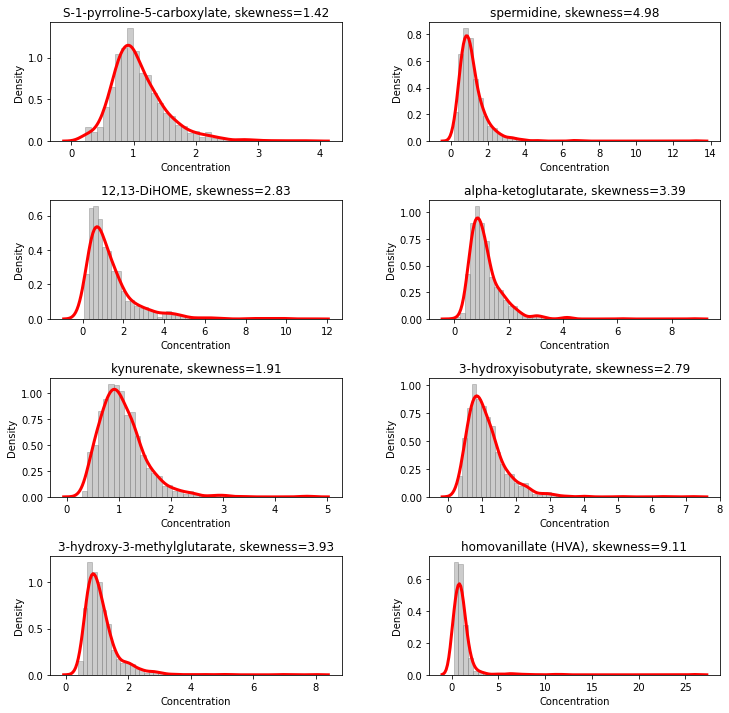

In [21]:
# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

# Flatten the subplot grid for easier indexing
axes = axes.flatten()

df = data_with_patient_metadata_reverse_log_transformed
for i, analyte in enumerate(analyte_columns_selected[0:8]):
    analyte_name = analyte_metadata[analyte_metadata["CHEM_ID"]==analyte]["CHEMICAL_NAME"].values[0]
    # Select the data for the current analyte
    subset = df[analyte]
    # Compute the skewness of the data
    skewness = round(subset.skew(), 2)
    # Plot the histogram and kde plot
    sns.distplot(subset, hist=True, kde=True, ax=axes[i], 
                 kde_kws={'color': 'r', 'lw': 3},
                 hist_kws={'color': 'gray', 'edgecolor': 'gray', 'linewidth': 1})
    # Set the title and axis labels
    axes[i].set_title(f"{analyte_name}, skewness={skewness}")
    axes[i].set_xlabel('Concentration')
    axes[i].set_ylabel('Density')
    
# Remove the unused subplots
for i in range(8, len(axes)):
    fig.delaxes(axes[i])
    
# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Show the plot
plt.show()

# print('Saving the figure ...')
# fig_filename = os.path.join(OUTPUT_PATH, "figures", "distribution_of_iMSMS_global_compounds_concentration_full_data_{}_reverse_log_transformed.svg".format(sample))
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


## Computing skewness for all analytes

100%|██████████| 1206/1206 [00:00<00:00, 1440.86it/s]


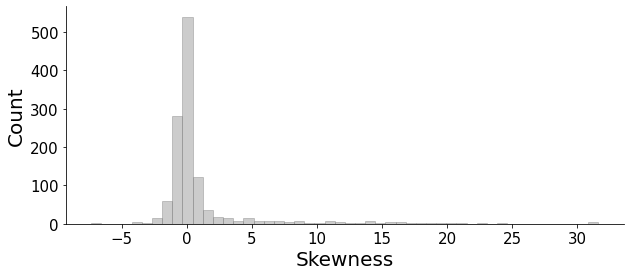

In [22]:
df = data_with_patient_metadata
analyte_skewness_list = []
for analyte in tqdm(analyte_columns_selected):
    analyte_name = analyte_metadata[analyte_metadata["CHEM_ID"]==analyte]["CHEMICAL_NAME"].values[0]
    subset = df[analyte]
    skewness = round(subset.skew(), 2)
    analyte_skewness_list.append((analyte, analyte_name, skewness))
    
analyte_skewness_df = pd.DataFrame(analyte_skewness_list, columns=["CHEM_ID", "CHEMICAL_NAME", "skewness"])


FIGSIZE = (10, 4)
FONTSIZE = 20

fig, ax = plt.subplots(figsize=FIGSIZE)
sns.distplot(analyte_skewness_df["skewness"], hist=True, kde=False, ax=ax, 
             kde_kws={'color': 'r', 'lw': 3},
             hist_kws={'color': 'gray', 'edgecolor': 'gray', 'linewidth': 1})


# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set the x label and title
plt.xlabel('Skewness',fontsize=FONTSIZE)
plt.ylabel('Count',fontsize=FONTSIZE)

plt.xticks(fontsize=FONTSIZE-5)
plt.yticks(fontsize=FONTSIZE-5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

# print('Saving the figure ...')
# fig_filename = os.path.join(OUTPUT_PATH, "figures", "skewness_distribution_of_iMSMS_global_compounds_full_data_{}_log_transformed.svg".format(sample))
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


## Computing skewness for all analytes after reversing log transformation

100%|██████████| 1206/1206 [00:00<00:00, 1342.65it/s]


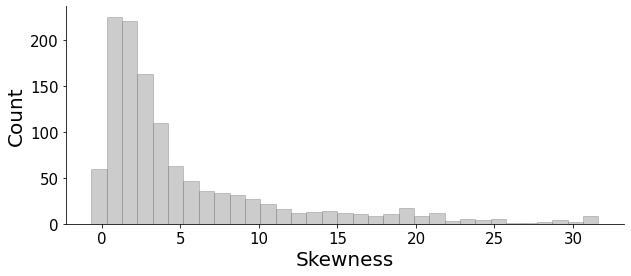

In [23]:
df = data_with_patient_metadata_reverse_log_transformed
analyte_skewness_list_reverse_log_transformed = []
for analyte in tqdm(analyte_columns_selected):
    analyte_name = analyte_metadata[analyte_metadata["CHEM_ID"]==analyte]["CHEMICAL_NAME"].values[0]
    subset = df[analyte]
    skewness = round(subset.skew(), 2)
    analyte_skewness_list_reverse_log_transformed.append((analyte, analyte_name, skewness))
    
analyte_skewness_df_reverse_log_transformed = pd.DataFrame(analyte_skewness_list_reverse_log_transformed, columns=["CHEM_ID", "CHEMICAL_NAME", "skewness"])


FIGSIZE = (10, 4)
FONTSIZE = 20

fig, ax = plt.subplots(figsize=FIGSIZE)
sns.distplot(analyte_skewness_df_reverse_log_transformed["skewness"], hist=True, kde=False, ax=ax, 
             kde_kws={'color': 'r', 'lw': 3},
             hist_kws={'color': 'gray', 'edgecolor': 'gray', 'linewidth': 1})


# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set the x label and title
plt.xlabel('Skewness',fontsize=FONTSIZE)
plt.ylabel('Count',fontsize=FONTSIZE)

plt.xticks(fontsize=FONTSIZE-5)
plt.yticks(fontsize=FONTSIZE-5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

# print('Saving the figure ...')
# fig_filename = os.path.join(OUTPUT_PATH, "figures", "skewness_distribution_of_iMSMS_global_compounds_full_data_{}_reverse_log_transformed.svg".format(sample))
# fig.savefig(fig_filename, format='svg', bbox_inches='tight')


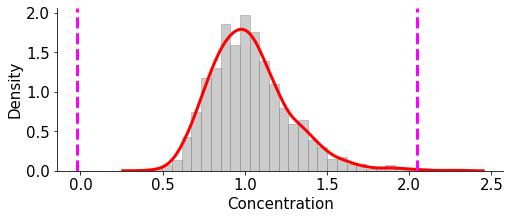

Saving the figure ...


In [32]:
'''
k = 3 is selected for Tukey Fences based on the following Ref:
    https://community.ibm.com/community/user/ai-datascience/blogs/moloy-de1/2021/03/23/points-to-ponder
'''

FIG_SIZE = (8,3)
FONTSIZE = 15

data_ = data_with_patient_metadata_reverse_log_transformed.copy()
analyte = analyte_columns_selected[16]
analyte_name = analyte_metadata[analyte_metadata["CHEM_ID"]==analyte]["CHEMICAL_NAME"].values[0]
sample_unit = data_["SAMPLE_AMOUNT_UNITS"].values[0]
analyte_concentration_values = data_[analyte]
# Calculate quartiles and IQR
q1 = analyte_concentration_values.quantile(0.25)
q3 = analyte_concentration_values.quantile(0.75)
iqr = q3 - q1
# Define Tukey's fences
k = 3
lower_fence = q1 - k * iqr
upper_fence = q3 + k * iqr
# Filter non-outliers
non_outliers = data_[(data_[analyte] >= lower_fence) & (data_[analyte] <= upper_fence)]
house_counts = non_outliers.groupby("house").size()

# Create a 4x4 subplot grid
fig, axes = plt.subplots(figsize=FIG_SIZE)


skewness = round(analyte_concentration_values.skew(), 2)
# Plot the histogram and kde plot
sns.distplot(analyte_concentration_values, hist=True, kde=True, ax=axes, 
             kde_kws={'color': 'r', 'lw': 3},
             hist_kws={'color': 'gray', 'edgecolor': 'gray', 'linewidth': 1})

# Add vertical bars for lower and upper fences
# axes.axvline(q1, color='blue', linestyle='--', label='Lower Fence', linewidth=3)
# axes.axvline(q3, color='blue', linestyle='--', label='Upper Fence', linewidth=3)

axes.axvline(lower_fence, color='magenta', linestyle='--', label='Lower Fence', linewidth=3)
axes.axvline(upper_fence, color='magenta', linestyle='--', label='Upper Fence', linewidth=3)


# Set the title and axis labels
# axes.set_title(f"{analyte_name}", fontsize=FONTSIZE)
axes.set_xlabel('Concentration', fontsize=FONTSIZE)
axes.set_ylabel('Density', fontsize=FONTSIZE)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)


# Show the plot
plt.show()

print('Saving the figure ...')
fig_filename = os.path.join(OUTPUT_PATH, "figures", "tukey_fence_demo_3_using_reverse_log_transformed_data_of_{}_analyte_of_{}_sample.svg".format(analyte, sample))
fig.savefig(fig_filename, format='svg', bbox_inches='tight')


In [141]:
# from scipy.stats import zscore
# data_to_plot = data_with_patient_metadata_reverse_log_transformed_nan_removed[analyte_columns_selected]
# data_zscore = data_to_plot.apply(zscore)
# data_zscore_T = data_zscore.T
# sns.heatmap(data_zscore_T, cmap='coolwarm', annot=True, fmt='.2f')
# plt.show()